# SWMAL Exercise

## Learning Curves

### The Generalization Error, Over- and Underfitting, Early Stopping, and Optimal Capacity

In this exercise, we need to explain all important overall concepts in training. Let's begin with Figure 5.3 from Deep Learning (Ian Goodfellow, et. al. [DL]), which pretty much sums it all up

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/dl_generalization_error.png" alt="WARNING: could not get image from server." style="height:500px">


### Qa) The Generalization Error

Write a detailed description of figure 5.3 (above) for your hand-in.
 
All concepts in the figure must be explained 

* training/generalization error, 
* underfit/overfit zone, 
* optimal capacity, 
* generalization gab, 
* and the two axes: x/capacity, y/error.

### Qb Learning Curves

Next, produce a loss vs epoch graph ala (from `04_training_linear_models.ipynb` [GITHOML]) 

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/training_curve.png" alt="WARNING: could not get image from server.">


for your linear regressor, `MyLinReg`, from an earlier lesson. You need a function 

>```LossHistory()```

on your regressor class, that accumulates the internally calculated $J$'s. Once `LossHistory` is ready, plot it using the code below.

In [ ]:
from sklearn.datasets import load_diabetes
from MyLinReg import MyLinReg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X, y = load_diabetes(return_X_y=True)
X = X[:, [2]]  # BMI feature

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

methods = ['batch', 'sgd', 'mini_batch']

for method in methods:
    r = MyLinReg(eta0=0.1, max_iter=100)
    r.fit(X_train, y_train, method)
    h = r.LossHistory()

    fig, ax = plt.subplots()
    plt.plot(h)
    ax.set_title(f"Loss history ({method.upper()})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("J")
    plt.show()


### Qc)  Early Stopping

Then implement ___early stopping___, in your `MyLinReg` estimator. Below is a graphical view of early stopping similar to Figure 4-20 p.162 [HOML] (for a non-linear model?)

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/early_stopping.png" alt="WARNING: could not get image from server.">

Write an explanation of the early stopping concept in text, implement it in your linear regressor and write some test/demo code, that via some learning-curve graphs demonstrates how it works when training your linear regressor in both _batch-gradient descent_ and 
_stochastic gradient descent_ modes.

--- Training with Batch Gradient Descent ---
Early stopping triggered at iteration 119 (Batch GD).

--- Training with Stochastic Gradient Descent ---
Early stopping triggered at epoch 46 (SGD).


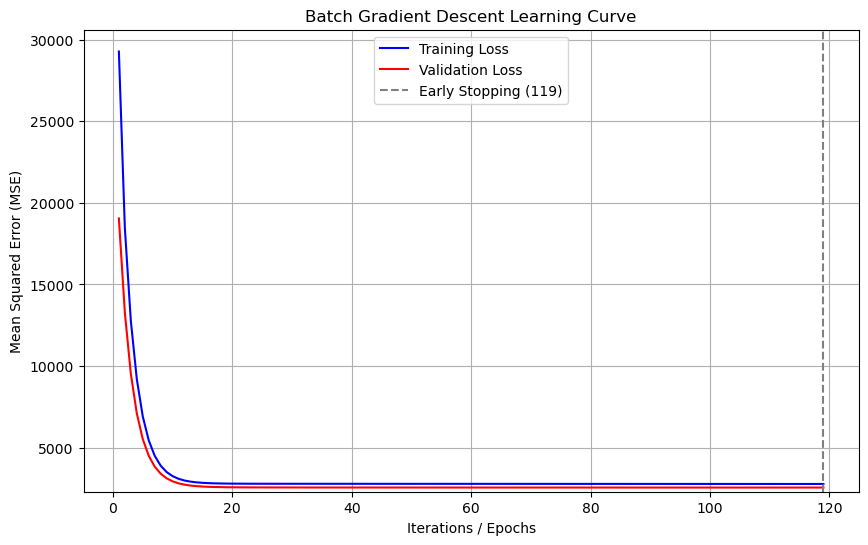

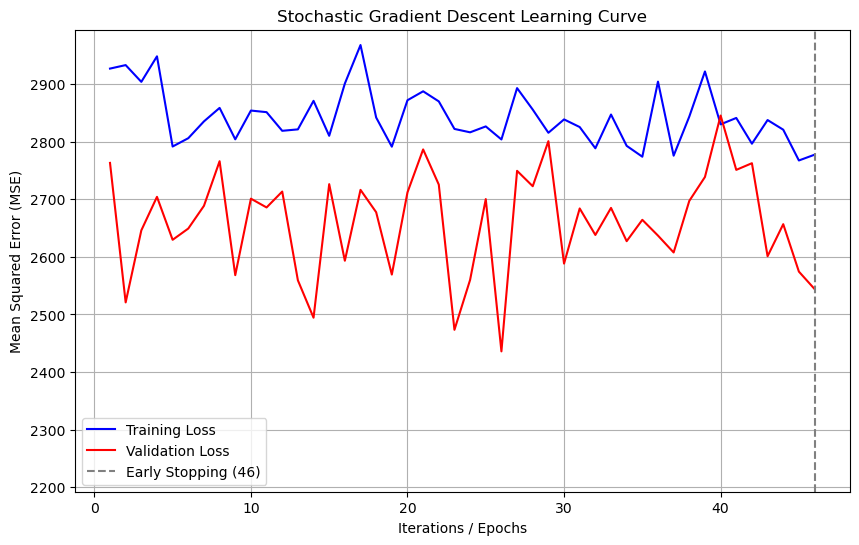


--- Final Model Evaluation ---
Batch GD - R^2 score on Test Set: 0.4225
SGD - R^2 score on Test Set: 0.4303

Comparison of final coefficients:
Batch GD Intercept: 152.5036
SGD Intercept: 151.5563


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from MyLinReg import MyLinReg


diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=98
)

# Scale the features (important for Gradient Descent)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)



# Configuration for early stopping
es_params = {
    'early_stopping': True,
    'validation_split': 0.2,
    'n_iter_no_change': 20,
    'tol': 1e-4
}

# --- Batch Gradient Descent ---
print("--- Training with Batch Gradient Descent ---")
lin_reg_batch = MyLinReg(
    eta0=0.1,
    max_iter=10000,
    **es_params
)


lin_reg_batch.fit(X_train_scaled, y_train_full, method='batch')

# --- Stochastic Gradient Descent ---
print("\n--- Training with Stochastic Gradient Descent ---")
lin_reg_sgd = MyLinReg(
    eta0=0.005,
    max_iter=500,                 
    **es_params
)

# Fit the model using the scaled training data
lin_reg_sgd.fit(X_train_scaled, y_train_full, method='sgd')

# --- 3. Plotting Learning Curves ---

# Function to plot learning curves
def plot_learning_curves(model, title):
    train_loss = model.LossHistory()
    val_loss = model.ValLossHistory()
    iterations = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_loss, 'b-', label='Training Loss')

    if model.early_stopping and val_loss:
        val_iterations = range(1, len(val_loss) + 1)
        plt.plot(val_iterations, val_loss, 'r-', label='Validation Loss')

        # Check if early stopping occurred (i.e., stopped before max_iter)
        # The number of validation scores recorded tells us when it stopped.
        stopped_iter = len(val_loss)
        if stopped_iter < model.max_iter:
             plt.axvline(x=stopped_iter, color='grey', linestyle='--',
                         label=f'Early Stopping ({stopped_iter})')

    plt.xlabel("Iterations / Epochs")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=min(min(train_loss), min(val_loss) if val_loss else np.inf) * 0.9) # Adjust y-axis slightly
    plt.show()

# Plot for Batch GD
plot_learning_curves(lin_reg_batch, "Batch Gradient Descent Learning Curve")

# Plot for SGD
plot_learning_curves(lin_reg_sgd, "Stochastic Gradient Descent Learning Curve")

# --- 4. (Optional) Evaluate on Test Set ---
print("\n--- Final Model Evaluation ---")
score_batch = lin_reg_batch.score(X_test_scaled, y_test)
score_sgd = lin_reg_sgd.score(X_test_scaled, y_test)
print(f"Batch GD - R^2 score on Test Set: {score_batch:.4f}")
print(f"SGD - R^2 score on Test Set: {score_sgd:.4f}")

print("\nComparison of final coefficients:")
print(f"Batch GD Intercept: {lin_reg_batch.intercept_:.4f}")
# print(f"Batch GD Coefs: {lin_reg_batch.coef_}")
print(f"SGD Intercept: {lin_reg_sgd.intercept_:.4f}")
# print(f"SGD Coefs: {lin_reg_sgd.coef_}")

### Qd:  [OPTIONAL]  Using a Polynomial Regressor to Produce an Error-vs-Capacity Graph

Finally, create a polynomial estimator based on your `MyLinReg`, see details of
how to expend a linear regressor to a polynomial fitting in [HOLM] or in

> https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html
 
that contains most of the code you will need. 
 
With a polynomial regressor, you should be able to reproduce a graph similar to Figure 5.3 from Deep Learning [DL], where you notice that the _x-axis_ is capacity and not _epoch_ as the learning curves you just produced in Qb/c.

### Qe Conclusion

Sum it all up in a nice, well-written conclusion.

REVISIONS||
:-|:-
2018-12-19| CEF, initial.                  
2018-02-14| CEF, major update and put in sync with under/overfitting exe.         
2018-02-20| CEF, fixed revision table malformatting.
2018-02-25| CEF, minor text updates, and made Qc optional.
2018-02-25| CEF, updated code, made more functions.
2018-03-11| CEF, corrected RSME to RMSE.
2019-10-08| CEF, updated to ITMAL E19.
2020-03-14| CEF, updated to ITMAL F20.
2020-10-15| CEF, updated to ITMAL E20.
2020-11-17| CEF, added a comment on 90-degree polynomial, made early stopping a pseudo code exe.
2021-03-22| CEF, changed crossref from "capacity_under_overfitting.ipynb Qc" to Qa+b in QdExplain the Polynomial RMSE-Capacity Plot. 
2021-03-23| CEF, changed 'cv RMSE' legend to 'validation RMSE'.
2021-10-31| CEF, updated to ITMAL E21.
2022-03-25| CEF, updated to SWMAL F22.
2023-03-16| CEF, minor update to SWMAL F23.
2024-09-25| CEF, major update, combined  generalization_error.ipynb and capacity_under_overfitting.ipynb, removed review parts, added graphs plots for MyLinReg.
2024-10-14| CEF, minor text updates.